In [66]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
from scipy import interpolate
pd.set_option('display.max_columns', 5000)  # or 1000
pd.set_option('display.max_rows', 5000)  # or 1000
import time
from numpy import concatenate
import matplotlib.pyplot as plt

# Specify the path and folder

In [197]:
trainning_folder = 'D:\PDF_Uppsala\Training dataset'
scenario_folder = 'D:\PDF_Uppsala\Work record\\3-Hydrodynamics from PM scenario'
GBR_folder = 'D:\PDF_Uppsala\Work record\\3-Hydrodynamics from PM scenario\GBR'
LSTM_folder = 'D:\PDF_Uppsala\Work record\\3-Hydrodynamics from PM scenario\LSTM'

# Load observation data and find the bloom events

In [190]:
# Load observation data
os.chdir(trainning_folder)
OB = pd.read_csv('ML_Chl_Selma.csv',sep = '\t',usecols = [0,1,2])
OB.columns = ['Date','Depth','Chl (mg/m3)']
OB = OB[OB['Depth']==-3]
OB.drop('Depth',axis =1,inplace = True)
OB['Date'] = pd.to_datetime(OB['Date'])
OB['Date'] = OB['Date'].apply(lambda d:d.date())
OB = OB[OB['Date']>=pd.Timestamp(2004,1,1)]

In [191]:
# Interpolate daily data
sdate = pd.Timestamp(2004,1,1)
edate = pd.Timestamp(2020,12,31)
OB_int = OB.set_index('Date').reindex(pd.date_range(start = sdate,end = edate,freq = '1D')).interpolate(method = 'linear')
OB_int.fillna(method = 'bfill',inplace = True)
OB_int = OB_int.reset_index()
OB_int.columns = ['Date','Chl (mg/m3)']
OB_int['Chl (mg/m3)'] = OB_int['Chl (mg/m3)'].rolling(7,min_periods = 1).mean()
OB_int['Date'] = OB_int['Date'].apply(lambda d:d.date())

In [192]:
OB_int['mm'] = OB_int['Date'].apply(lambda d:d.month)
OB_int = OB_int[(OB_int['mm']>=4) &(OB_int['mm']<=11)] # Select Apr - Nov
OB_int.drop('mm',axis =1,inplace = True)

In [193]:
# Use the delta_Chl threshold to find the onset dates of algal bloom
OB_int['delta_Chl'] = np.diff(OB_int['Chl (mg/m3)'],append=0)
OB_int['Bloom'] = OB_int['delta_Chl'].apply(lambda x: 1 if x>threshold else 0) 
OB_int['Date'] = pd.to_datetime(OB_int['Date'])
OB_bloom = OB_int[['Date','Bloom']]

# Load the ML model results and find predicted bloom events

In [194]:
# GBR model
os.chdir(GBR_folder)
Erken_Nut = pd.read_csv('GBR predicted nutrient_predicted nutrient and Chl.csv',sep = ',')
ML_Chl = Erken_Nut[['Date','Chl(mg/m3)']]
ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
ML_Chl['Delta_Chl'] = np.diff(Erken_Nut['Chl(mg/m3)'],append = 0)
ML_Chl['Bloom'] = ML_Chl['Delta_Chl'].apply(lambda x: 1 if x>threshold else 0)
ML_bloom = ML_Chl[['Date','Bloom']]

# Find the model hits the events or not
Event_detection = OB_bloom.merge(ML_bloom,how = 'inner',on = 'Date')
Event_detection.columns = ['Date','OB','ML']
Event_detection['Hits'] = np.where((Event_detection['OB'] == 1) & (Event_detection['ML']==1), 1, 0)
Event_detection['YY'] = Event_detection['Date'].apply(lambda d:d.year)
year = Event_detection['YY'].unique()
Probability  =[]
for i in range(len(year)):    
    Probability.append(Event_detection[Event_detection['YY']==year[i]]['Hits'].value_counts()[1]/Event_detection[Event_detection['YY']==year[i]]['OB'].value_counts()[1])
Prob = pd.DataFrame(np.array(Probability),index = year)
Prob.columns = ['Probability']
Prob.to_csv('Probability.csv',index = True)
Prob_compare = Prob.copy()
Prob_compare.columns = ['GBR']

<ipython-input-194-14f36e78fbb7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
<ipython-input-194-14f36e78fbb7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
<ipython-input-194-14f36e78fbb7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [195]:
# LSTM model
os.chdir(LSTM_folder)
Erken_Nut = pd.read_csv('LSTM predicted nutrient and Chl data.csv',sep = ',')
ML_Chl = Erken_Nut[['Date','Chl(mg/m3)']]
ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
ML_Chl['Delta_Chl'] = np.diff(Erken_Nut['Chl(mg/m3)'],append = 0)
ML_Chl['Bloom'] = ML_Chl['Delta_Chl'].apply(lambda x: 1 if x>threshold else 0)
ML_bloom = ML_Chl[['Date','Bloom']]

# Find the model hits the events or not
Event_detection = OB_bloom.merge(ML_bloom,how = 'inner',on = 'Date')
Event_detection.columns = ['Date','OB','ML']
Event_detection['Hits'] = np.where((Event_detection['OB'] == 1) & (Event_detection['ML']==1), 1, 0)
Event_detection['YY'] = Event_detection['Date'].apply(lambda d:d.year)
Event_detection = Event_detection[Event_detection['YY']>=2017]
year = Event_detection['YY'].unique()
Probability  =[]
for i in range(len(year)):    
    Probability.append(Event_detection[Event_detection['YY']==year[i]]['Hits'].value_counts()[1]/Event_detection[Event_detection['YY']==year[i]]['OB'].value_counts()[1])
Prob = pd.DataFrame(np.array(Probability),index = year)
Prob.columns = ['Probability']
Prob.to_csv('Probability.csv',index = True)
Prob_compare = Prob_compare.join(Prob,how='left')
Prob_compare.columns = ['GBR','LSTM']

<ipython-input-195-34ef1565382a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
<ipython-input-195-34ef1565382a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
<ipython-input-195-34ef1565382a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

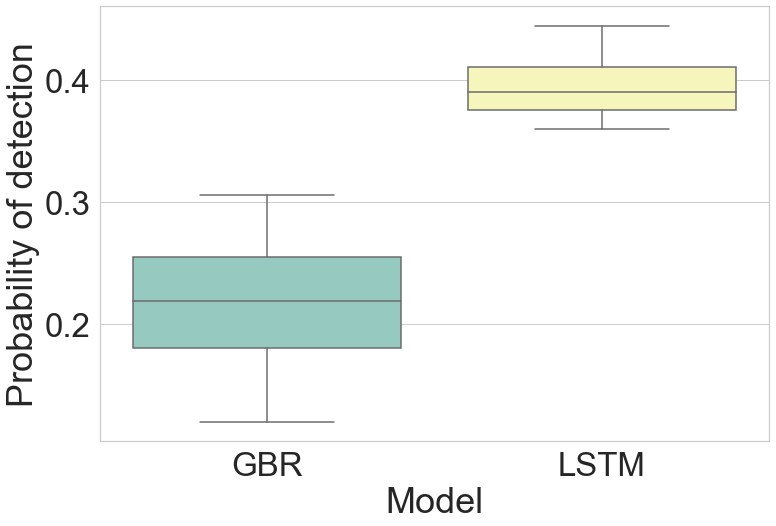

In [196]:
os.chdir(scenario_folder)
sns.set_theme(style = 'whitegrid',font_scale=3)
f1,ax = plt.subplots(figsize = (12,8))
sns.boxplot(data = Prob_compare,palette="Set3",ax = ax)
ax.set_ylabel('Probability of detection')
ax.set_xlabel('Model')
f1.savefig('Probability of detection.png',dpi = 500)

# Data sparsity test

# Specify the paths

In [253]:
GBR_save_folder = 'D:\\PDF_Uppsala\\Work record\\3-Hydrodynamics from PM scenario\\Data frequency sensitivity test\\GBR\\2-testing leave one year out'
LSTM_save_folder = 'D:\\PDF_Uppsala\\Work record\\3-Hydrodynamics from PM scenario\\Data frequency sensitivity test\\LSTM\\2-testing leave one year out'

In [254]:
# Create an empty metrics
Metrics=[]
RMSE_avg = []
R2_avg = []
# Set a threshold for algal bloom onset
threshold = 0.3

In [255]:
# Load ML model data
dataset_folder = ['Original','7days','10days','14days','21days','28days','35days']
filename = 'LSTM predicted nutrient_predicted nutrient and Chl.csv' #'GBR predicted nutrient_predicted nutrient and Chl.csv'
for j in range(len(dataset_folder)):
    os.chdir(LSTM_save_folder+'\\'+dataset_folder[j])
    Erken_Nut = pd.read_csv(filename,sep = ',')
    ML_Chl = Erken_Nut[['Date','Chl(mg/m3)']]
    ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
    ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
    ML_Chl['Delta_Chl'] = np.diff(Erken_Nut['Chl(mg/m3)'],append = 0)
    ML_Chl['Bloom'] = ML_Chl['Delta_Chl'].apply(lambda x: 1 if x>threshold else 0)
    ML_bloom = ML_Chl[['Date','Bloom']]

    # Find the model hits the events or not
    Event_detection = OB_bloom.merge(ML_bloom,how = 'inner',on = 'Date')
    Event_detection.columns = ['Date','OB','ML']
    Event_detection['Hits'] = np.where((Event_detection['OB'] == 1) & (Event_detection['ML']==1), 1, 0)
    Event_detection['YY'] = Event_detection['Date'].apply(lambda d:d.year)
    year = Event_detection['YY'].unique()
    Probability  =[]
    for i in range(len(year)):
        if len(Event_detection[Event_detection['YY']==year[i]]['Hits'].value_counts())>1:
            Probability.append(Event_detection[Event_detection['YY']==year[i]]['Hits'].value_counts()[1]/Event_detection[Event_detection['YY']==year[i]]['OB'].value_counts()[1])
        else:
            Probability.append(0)
    Prob = pd.DataFrame(np.array(Probability),index = year)
    Prob.columns = ['Probability']
    Prob.to_csv('Probability.csv',index = True)
    
    # Compute the probability
    Probability = Event_detection['Hits'].value_counts()[1]/Event_detection['OB'].value_counts()[1]
    Metrics.append(Probability)
    RMSE = pd.read_csv('RMSE.csv',sep = ',')
    RMSE_avg.append(RMSE['Chl'].mean())
    R2 = pd.read_csv('R2.csv',sep = ',')
    R2_avg.append(R2['Chl'].mean())

<ipython-input-255-896fecab01ef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
<ipython-input-255-896fecab01ef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
<ipython-input-255-896fecab01ef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

<ipython-input-255-896fecab01ef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
<ipython-input-255-896fecab01ef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
<ipython-input-255-896fecab01ef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [256]:
os.chdir(LSTM_save_folder)
pd.DataFrame({'Probability':Metrics,'RMSE':RMSE_avg,'R2':R2_avg},index = dataset_folder).to_csv('Evaluation.csv',index = True)

In [257]:
Probability = pd.DataFrame(columns = dataset_folder)
RMSE = pd.DataFrame(columns = dataset_folder)
R2 = pd.DataFrame(columns = dataset_folder)
for i in range(len(dataset_folder)):
    os.chdir(LSTM_save_folder+'\\'+dataset_folder[i])
    Probability[dataset_folder[i]] = pd.read_csv('Probability.csv',sep = ',')['Probability']
    RMSE[dataset_folder[i]] = pd.read_csv('RMSE.csv',sep = ',')['Chl']
    R2[dataset_folder[i]] = pd.read_csv('R2.csv',sep = ',')['Chl']
Probability.index = list(range(2004,2021))  
RMSE.index = list(range(2004,2021)) 
R2.index = list(range(2004,2021)) 

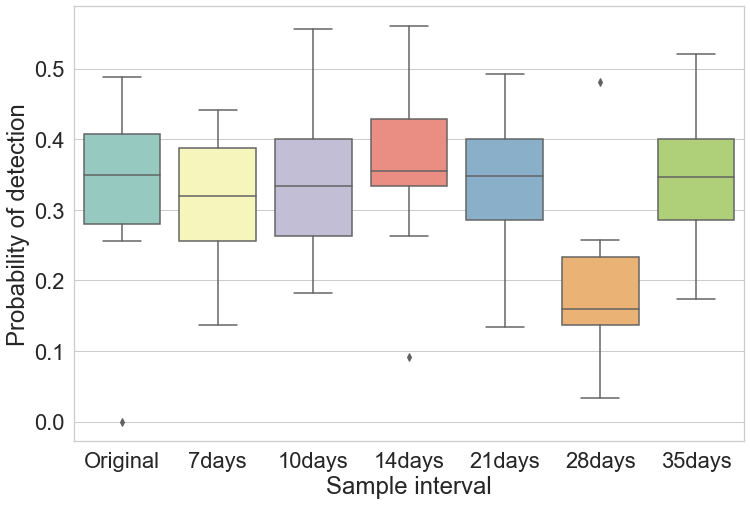

In [258]:
os.chdir(LSTM_save_folder)
sns.set_theme(style = 'whitegrid',font_scale=2)
f1,ax = plt.subplots(figsize = (12,8))
sns.boxplot(data = Probability[dataset_folder],palette="Set3",ax = ax)
ax.set_ylabel('Probability of detection')
ax.set_xlabel('Sample interval')
f1.savefig('Probability of detection.png',dpi = 500)

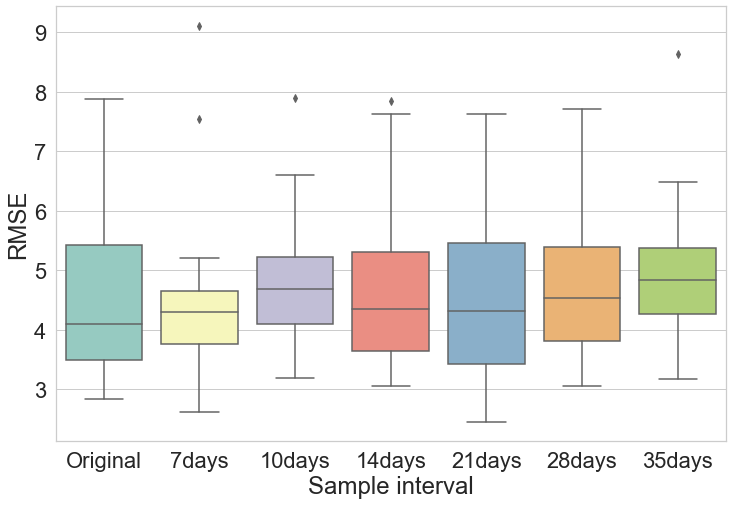

In [259]:
f2,ax = plt.subplots(figsize = (12,8))
sns.boxplot(data = RMSE[dataset_folder],palette="Set3",ax = ax)
ax.set_ylabel('RMSE')
ax.set_xlabel('Sample interval')
f2.savefig('RMSE.png',dpi = 500)

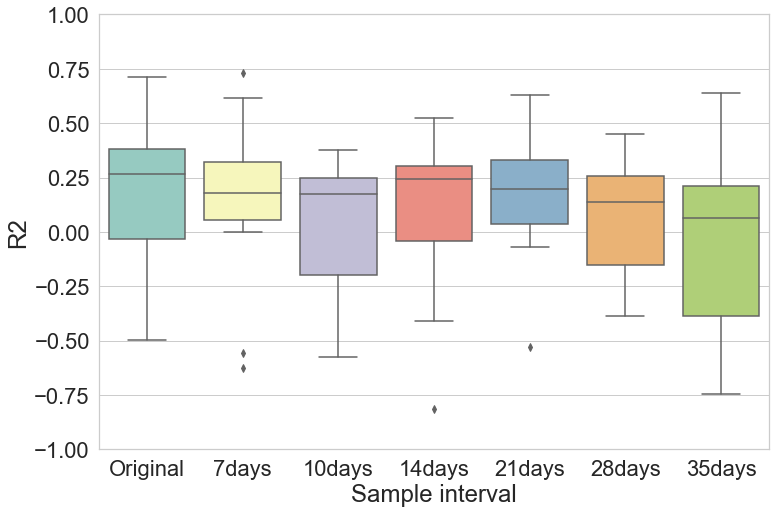

In [262]:
f3,ax = plt.subplots(figsize = (12,8))
sns.boxplot(data = R2[dataset_folder],palette="Set3",ax = ax)
ax.set_ylabel('R2')
ax.set_xlabel('Sample interval')
ax.set_ylim(-1,1)
f3.savefig('R2.png',dpi = 500)

# Plot the leave_one_year_out test results

<ipython-input-263-7594c98c549c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
<ipython-input-263-7594c98c549c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
<ipython-input-263-7594c98c549c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

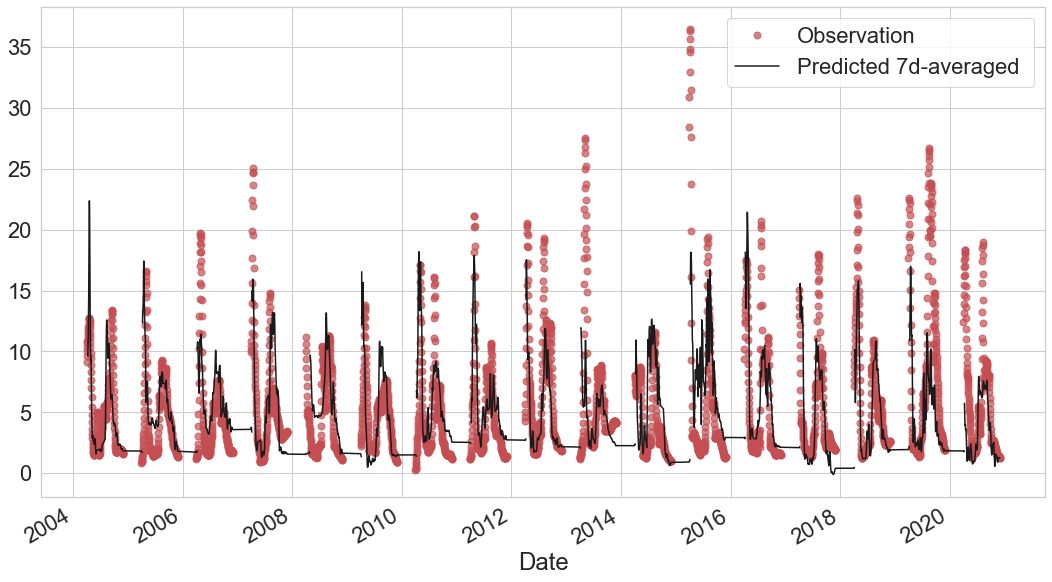

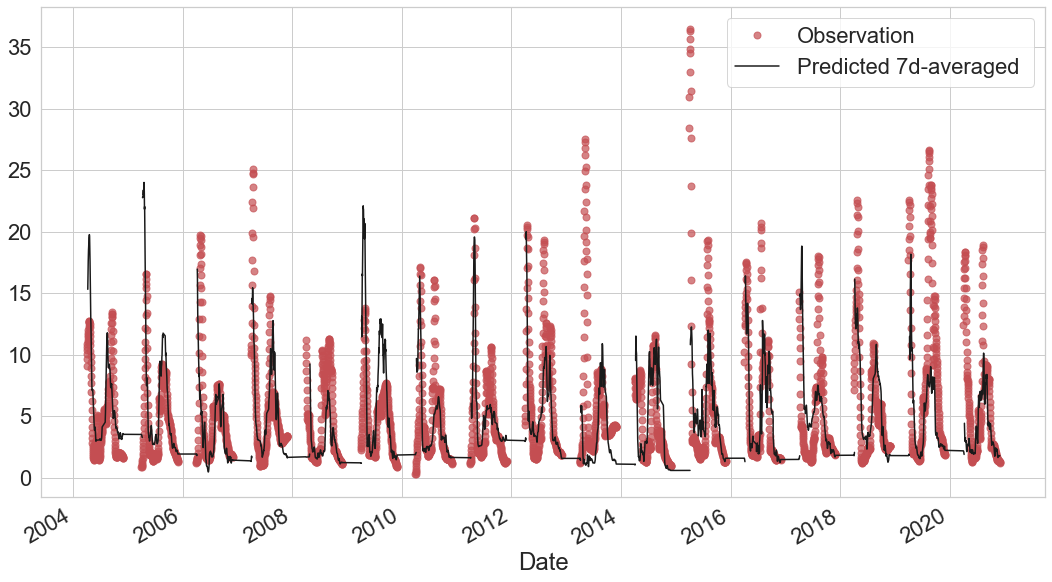

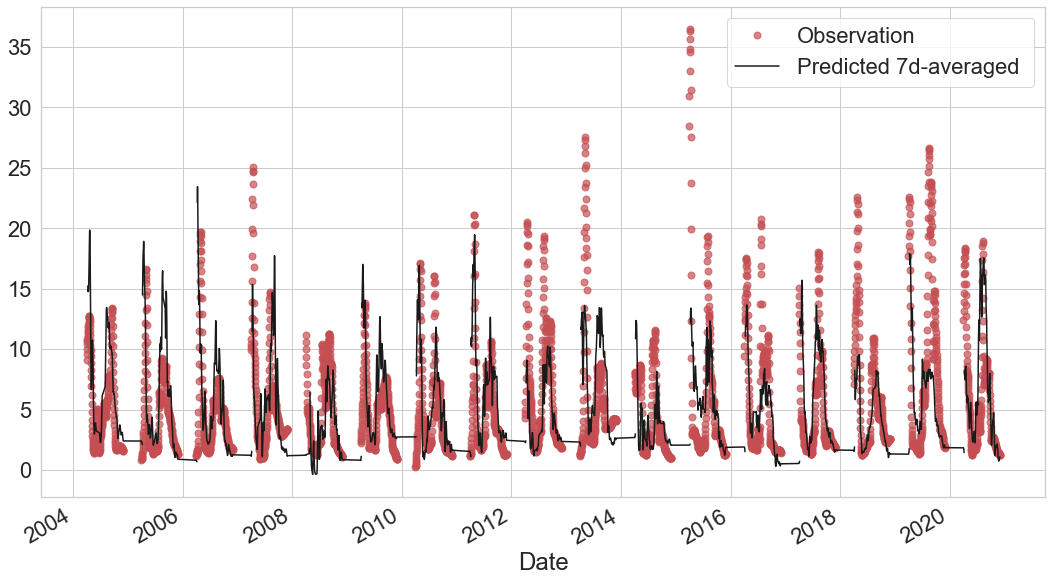

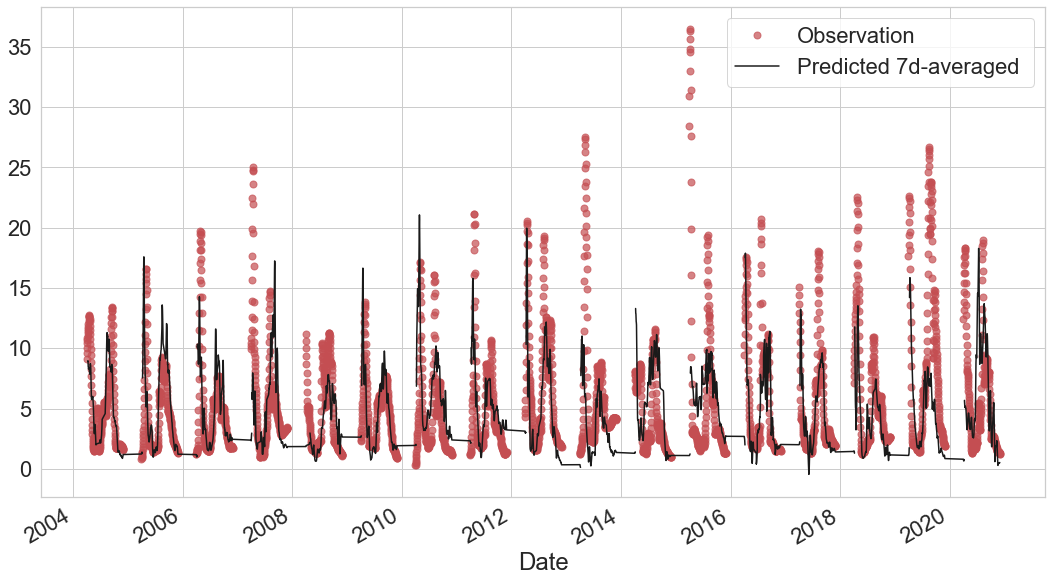

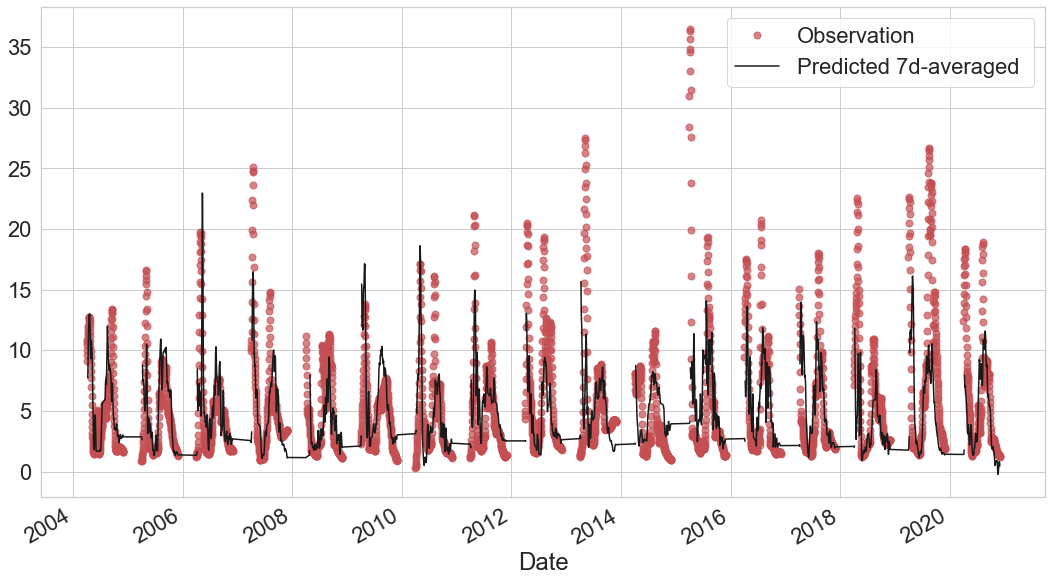

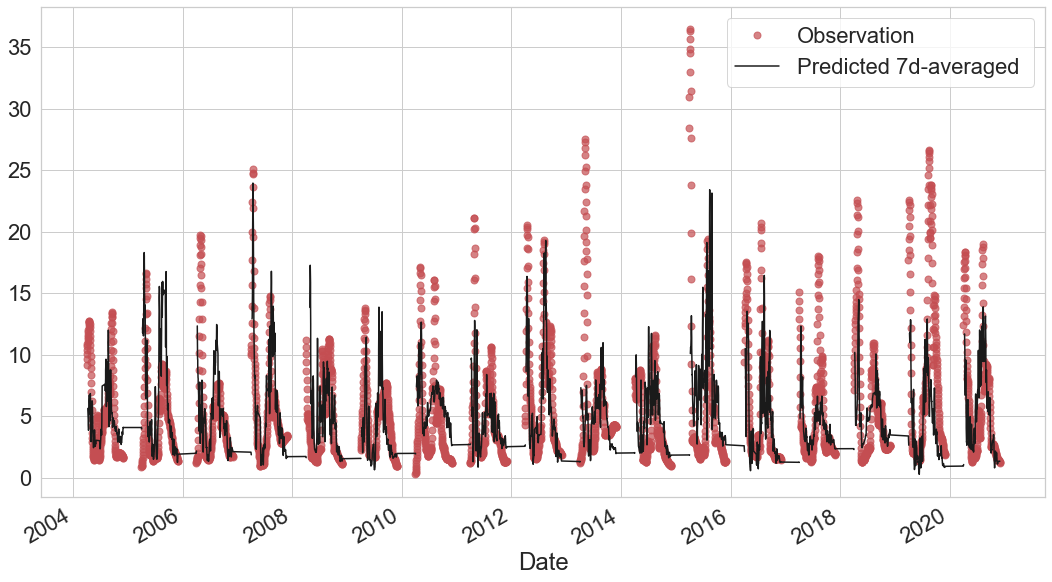

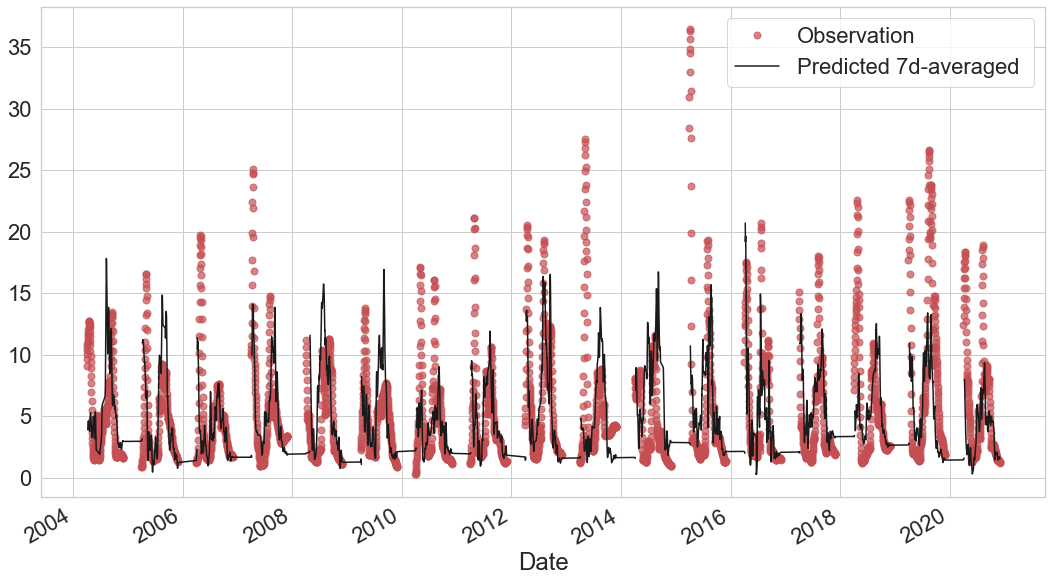

In [263]:
dataset_folder = ['Original','7days','10days','14days','21days','28days','35days']
filename = 'LSTM predicted nutrient_predicted nutrient and Chl.csv'#'GBR predicted nutrient_predicted nutrient and Chl.csv'
for i in range(len(dataset_folder)):
    os.chdir(LSTM_save_folder+'\\'+dataset_folder[i])
    Erken_Nut = pd.read_csv(filename,sep = ',')
    ML_Chl = Erken_Nut[['Date','Chl(mg/m3)']]
    ML_Chl['Date'] = pd.to_datetime(ML_Chl['Date'])
    ML_Chl['Chl(mg/m3)'] = ML_Chl['Chl(mg/m3)'].rolling(7,min_periods = 1).mean() # Get 7-day rolling mean of Ch
    f,ax = plt.subplots(figsize = (18,10))
    OB_int.plot(x = 'Date',y = 'Chl (mg/m3)',style = 'ro',ms = 7,alpha = 0.7,ax = ax,label = 'Observation')
    ML_Chl.plot(x = 'Date',y = 'Chl(mg/m3)',c = 'k',ax = ax,label = 'Predicted 7d-averaged ')
    f.savefig('Leave_one_year_out test.png',dpi = 300)